In [4]:
import os
import functools
from itertools import groupby
import operator
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Seq import Seq
from Bio import SeqIO

from dwave.system import LeapHybridCQMSampler
from dimod import Binary, ConstrainedQuadraticModel

from codon_hamiltonian import *

## 0. DNA(amino acid) Sequance

In [2]:
tox_human = 'MDVRFYPPPAQPAAAPDAPCLGPSPCLDPYYCNKFDGENMYMSMTEPSQDYVPASQSYPGPSLESEDFNIPPITPPSLPDHSLVHLNEVESGYHSLCHPMNHNGLLPFHPQNMDLPEITVSNMLGQDGTLLSNSISVMPDIRNPEGTQYSSHPQMAAMRPRGQPADIRQQPGMMPHGQLTTINQSQLSAQLGLNMGGSNVPHNSPSPPGSKSATPSPSSSVHEDEGDDTSKINGGEKRPASDMGKKPKTPKKKKKKDPNEPQKPVSAYALFFRDTQAAIKGQNPNATFGEVSKIVASMWDGLGEEQKQVYKKKTEAAKKEYLKQLAAYRASLVSKSYSEPVDVKTSQPPQLINSKPSVFHGPSQAHSALYLSSHYHQQPGMNPHLTAMHPSLPRNIAPKPNNQMPVTVSIANMAVSPPPPLQISPPLHQHLNMQQHQPLTMQQPLGNQLPMQVQSALHSPTMQQGFTLQPDYQTIINPTSTAAQVVTQAMEYVRSGCRNPPPQPVDWNNDYCSSGGMQRDKALYLT'
tox_mouse = 'MDVRFYPPPAQPAAAPAAPCLGPSPCLDPYYCNKFDGENMYMSMTEPSQDYVPASQSYPGPSLESEDFNIPPITPPSLPDHSLVHLNEVESGYHSLCHPMNHNGLLPFHPQTMDLPEITVSNMLGQDGALLSNSISVMQEIGNAEGAQYSSHPQMAAMRPRGQPTDIRQQASMMQPGQLTTINQSQLSAQLGLNMGGTNVAHNSPSPPGSKSATPSPSSSVHEDECEDASKINGGEKRPASDMGKKPKTPKKKKKKDPNEPQKPVSAYALFFRDTQAAIKGQNPNATFGEVSKIVASMWDGLGEEQKQVYKKKTEAAKKEYLKQLAAYRASLVSKSYTDPVDVKTSQPPQLVNSKPSVFHGPSQAHSALYLSSHYHQQPGMTPQLTAMHPSLPRNIAPKPNNQMPVTVSIANMAVSPPPPLQISPPLHQHLSMQQHQSLAMQQPLGSQLPMQVQTALHSPTMQQGFTLQPDYQTIINPTSTAAQVVTQAMEYVRSGCRNPPPQPVDWSTDYCSSGGMQRDKALYLT'
wnt11_human = 'MRARPQVCEALLFALALQTGVCYGIKWLALSKTPSALALNQTQHCKQLEGLVSAQVQLCRSNLELMHTVVHAAREVMKACRRAFADMRWNCSSIELAPNYLLDLERGTRESAFVYALSAAAISHAIARACTSGDLPGCSCGPVPGEPPGPGNRWGGCADNLSYGLLMGAKFSDAPMKVKKTGSQANKLMRLHNSEVGRQALRASLEMKCKCHGVSGSCSIRTCWKGLQELQDVAADLKTRYLSATKVVHRPMGTRKHLVPKDLDIRPVKDSELVYLQSSPDFCMKNEKVGSHGTQDRQCNKTSNGSDSCDLMCCGRGYNPYTDRVVERCHCKYHWCCYVTCRRCERTVERYVCK'

or

In [3]:
records_gene = SeqIO.read("./TOX_human_datasets/ncbi_dataset/data/gene.fna", "fasta")
records_rna = SeqIO.read("./TOX_human_datasets/ncbi_dataset/data/rna.fna", "fasta")
records_protein = SeqIO.read("./TOX_human_datasets/ncbi_dataset/data/protein.faa", "fasta")

In [4]:
tox_human_dna = 'ATGGACGTAAGATTTTATCCACCTCCAGCCCAGCCCGCCGCTGCGCCCGACGCTCCCTGTCTGGGACCTTCTCCCTGCCTGGACCCCTACTATTGCAACAAGTTTGACGGTGAGAACATGTATATGAGCATGACAGAGCCGAGCCAGGACTATGTGCCAGCCAGCCAGTCCTACCCTGGTCCAAGCCTGGAAAGTGAAGACTTCAACATTCCACCAATTACTCCTCCTTCCCTCCCAGACCACTCGCTGGTGCACCTGAATGAAGTTGAGTCTGGTTACCATTCTCTGTGTCACCCCATGAACCATAATGGCCTGCTACCATTTCATCCACAAAACATGGACCTCCCTGAAATCACAGTCTCCAATATGCTGGGCCAGGATGGAACACTGCTTTCTAATTCCATTTCTGTGATGCCAGATATACGAAACCCAGAAGGAACTCAGTACAGTTCCCATCCTCAGATGGCAGCCATGAGACCAAGGGGCCAGCCTGCAGACATCAGGCAGCAGCCAGGAATGATGCCACATGGCCAGCTGACTACCATTAACCAGTCACAGCTAAGTGCTCAACTTGGTTTGAATATGGGAGGAAGCAATGTTCCCCACAACTCACCATCTCCACCTGGAAGCAAGTCTGCAACTCCTTCACCATCCAGTTCAGTGCATGAAGATGAAGGCGATGATACCTCTAAGATCAATGGTGGAGAGAAGCGGCCTGCCTCTGATATGGGGAAAAAACCAAAAACTCCCAAAAAGAAGAAGAAGAAGGATCCCAATGAGCCCCAGAAGCCTGTGTCTGCCTATGCGTTATTCTTTCGTGATACTCAGGCCGCCATCAAGGGCCAAAATCCAAACGCTACCTTTGGCGAAGTCTCTAAAATTGTGGCTTCAATGTGGGACGGTTTAGGAGAAGAGCAAAAACAGGTCTATAAAAAGAAAACCGAGGCTGCGAAGAAGGAGTACCTGAAGCAACTCGCAGCATACAGAGCCAGCCTTGTATCCAAGAGCTACAGTGAACCTGTTGACGTGAAGACATCTCAACCTCCTCAGCTGATCAATTCGAAGCCGTCGGTGTTCCATGGGCCCAGCCAGGCCCACTCGGCCCTGTACCTAAGTTCCCACTATCACCAACAACCGGGAATGAATCCTCACCTAACTGCCATGCATCCTAGTCTCCCCAGGAACATAGCCCCCAAGCCGAATAACCAAATGCCAGTGACTGTCTCTATAGCAAACATGGCTGTGTCCCCTCCTCCTCCCCTCCAGATCAGCCCGCCTCTTCACCAGCATCTCAACATGCAGCAGCACCAGCCGCTCACCATGCAGCAGCCCCTTGGGAACCAGCTCCCCATGCAGGTCCAGTCTGCCTTACACTCACCCACCATGCAGCAAGGATTTACTCTTCAACCCGACTATCAGACTATTATCAATCCTACATCTACAGCTGCACAAGTTGTCACCCAGGCAATGGAGTATGTGCGTTCGGGGTGCAGAAATCCTCCCCCACAACCGGTGGACTGGAATAACGACTACTGCAGTAGTGGGGGCATGCAGAGGGACAAAGCACTGTACCTTACT'
tox_mouse_dna = 'ATGGACGTAAGATTTTATCCTCCTCCAGCCCAGCCCGCTGCTGCGCCCGCCGCTCCTTGTCTGGGACCTTCTCCCTGCCTGGACCCCTACTATTGCAACAAGTTTGACGGGGAGAACATGTATATGAGCATGACAGAGCCGAGCCAGGACTATGTGCCAGCCAGCCAGTCCTACCCTGGACCAAGTCTGGAAAGTGAAGATTTTAACATCCCACCCATCACGCCTCCCTCCCTCCCTGACCACTCTCTGGTGCACCTGAATGAGGTAGAATCCGGTTACCACTCTCTGTGTCACCCCATGAATCACAATGGCCTGCTCCCGTTCCATCCACAAACCATGGACCTGCCAGAGATCACGGTGTCCAACATGCTGGGCCAAGATGGCGCACTGCTCTCCAATTCCATCTCTGTGATGCAAGAGATTGGGAACGCAGAAGGAGCTCAGTACAGCTCCCATCCTCAGATGGCAGCCATGAGGCCGAGAGGCCAGCCTACAGACATCAGACAGCAGGCAAGCATGATGCAGCCCGGCCAGCTGACCACCATCAACCAGTCGCAGCTGAGCGCACAGTTGGGCTTGAACATGGGAGGAACCAATGTGGCCCACAACTCCCCTTCTCCACCCGGGAGCAAGTCTGCAACCCCTTCCCCATCCAGCTCAGTGCATGAGGATGAGTGTGAGGATGCCTCCAAGATCAATGGAGGAGAGAAGCGGCCTGCCTCTGATATGGGGAAAAAACCCAAAACTCCCAAGAAGAAGAAGAAGAAGGATCCTAATGAGCCCCAGAAGCCTGTGTCTGCCTATGCTTTGTTCTTTCGTGATACCCAGGCTGCCATTAAGGGCCAGAATCCAAATGCTACTTTTGGTGAAGTATCGAAGATTGTGGCATCAATGTGGGATGGCCTAGGAGAAGAACAGAAACAGGTCTATAAGAAGAAAACCGAGGCTGCAAAGAAGGAATACCTGAAGCAGCTAGCAGCATACAGAGCCAGCCTTGTATCCAAGAGCTACACTGATCCTGTTGATGTTAAGACATCTCAGCCACCCCAGCTGGTCAACTCAAAGCCGTCAGTATTCCATGGGCCCAGCCAGGCCCACTCAGCTCTGTACCTAAGTTCTCACTATCACCAACAACCAGGAATGACTCCTCAGCTCACCGCCATGCATCCGAGCCTCCCCAGAAACATAGCACCTAAGCCCAATAACCAAATGCCAGTGACTGTCTCCATAGCCAACATGGCTGTGTCCCCACCACCGCCCCTTCAGATCAGCCCACCTCTTCATCAGCATCTCAGCATGCAGCAGCATCAGTCGCTTGCCATGCAGCAGCCCCTTGGGAGTCAGCTCCCCATGCAGGTCCAGACTGCCTTACACTCGCCCACCATGCAGCAAGGATTTACTCTTCAACCCGACTATCAGACTATTATCAACCCTACATCTACAGCTGCACAAGTTGTCACCCAAGCGATGGAGTACGTGCGTTCTGGGTGCAGAAATCCGCCCCCACAGCCCGTGGACTGGAGTACCGACTACTGCAGTAGTGGGGGCATGCAGAGGGACAAAGCGCTGTATCTCACC'
wnt11_human_dna = 'ATGAGGGCGCGGCCGCAGGTCTGCGAGGCGCTGCTCTTCGCCCTGGCGCTCCAGACCGGCGTGTGCTATGGCATCAAGTGGCTGGCGCTGTCCAAGACACCATCGGCCCTGGCACTGAACCAGACGCAACACTGCAAGCAGCTGGAGGGTCTGGTGTCTGCACAGGTGCAGCTGTGCCGCAGCAACCTGGAGCTCATGCACACGGTGGTGCACGCCGCCCGCGAGGTCATGAAGGCCTGTCGCCGGGCCTTTGCCGACATGCGCTGGAACTGCTCCTCCATTGAGCTCGCCCCCAACTATTTGCTTGACCTGGAGAGAGGGACCCGGGAGTCGGCCTTCGTGTATGCGCTGTCGGCCGCCGCCATCAGCCACGCCATCGCCCGGGCCTGCACCTCCGGCGACCTGCCCGGCTGCTCCTGCGGCCCCGTCCCAGGTGAGCCACCCGGGCCCGGGAACCGCTGGGGAGGATGTGCGGACAACCTCAGCTACGGGCTCCTCATGGGGGCCAAGTTTTCCGATGCTCCTATGAAGGTGAAAAAAACAGGATCCCAAGCCAATAAACTGATGCGTCTACACAACAGTGAAGTGGGGAGACAGGCTCTGCGCGCCTCTCTGGAAATGAAGTGTAAGTGCCATGGGGTGTCTGGCTCCTGCTCCATCCGCACCTGCTGGAAGGGGCTGCAGGAGCTGCAGGATGTGGCTGCTGACCTCAAGACCCGATACCTGTCGGCCACCAAGGTAGTGCACCGACCCATGGGCACCCGCAAGCACCTGGTGCCCAAGGACCTGGATATCCGGCCTGTGAAGGACTCGGAACTCGTCTATCTGCAGAGCTCACCTGACTTCTGCATGAAGAATGAGAAGGTGGGCTCCCACGGGACACAAGACAGGCAGTGCAACAAGACATCCAACGGAAGCGACAGCTGCGACCTTATGTGCTGCGGGCGTGGCTACAACCCCTACACAGACCGCGTGGTCGAGCGGTGCCACTGTAAGTACCACTGGTGCTGCTACGTCACCTGCCGCAGGTGTGAGCGTACCGTGGAGCGCTATGTCTGCAAG'

## 1. TOX_HUMAN OS=h_sapiens, OX=9606

In [45]:
name = 'TOX_HUMAN'
aa_seq = tox_human
weight_params = {'cub_h1': 1, 'cub_h2': 1, 'cpub_h1': 1, 'cpub_h2': 1, 'rep_nuc': 1, 'rho_T': 0.6, 'B_rho': 0.05}
hosts = ['e_coli', 'h_sapiens']

In [46]:
H_codon = Codon_Hamiltonian(aa_seq, weight_params)
codon_opt = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1])
opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
opt_codon_seq

47 feasible solutions of 61.


'ATGGATGTGCGCTTCTATCCGCCGCCGGCACAGCCAGCAGCAGCACCTGATGCACCTTGTCTCGGTCCTTCACCTTGTCTGGATCCATACTACTGCAACAAGTTCGATGGCGAGAACATGTACATGAGCATGACAGAGCCTTCACAGGACTATGTGCCGGCATCACAGAGCTATCCAGGACCATCGCTGGAGAGTGAGGACTTCAACATTCCACCAATCACGCCGCCGTCGCTGCCTGATCACTCGCTGGTGCATCTGAATGAAGTAGAGAGCGGCTATCACTCGCTGTGTCATCCAATGAACCACAACGGCCTGCTGCCGTTCCATCCGCAGAACATGGATCTGCCTGAGATCACTGTCAGTAACATGCTCGGTCAGGATGGCACGCTGCTGAGCAACAGCATCAGCGTGATGCCAGACATCCGCAATCCAGAAGGCACTCAGTACAGCAGTCATCCACAGATGGCAGCGATGCGTCCACGTGGTCAGCCTGCTGACATCCGTCAGCAGCCAGGAATGATGCCACATGGTCAGCTGACTACTATCAACCAGAGTCAGCTCTCTGCACAGCTCGGTCTGAACATGGGCGGCAGCAACGTGCCACACAACAGTCCTTCTCCGCCAGGCAGCAAGTCAGCGACACCTTCTCCTTCCAGCAGCGTGCATGAAGATGAAGGTGATGACACTAGCAAGATCAATGGCGGCGAGAAGCGTCCTGCATCTGACATGGGCAAGAAGCCTAAGACACCGAAGAAGAAGAAGAAGAAGGATCCGAATGAGCCGCAGAAGCCAGTATCAGCATATGCGCTGTTCTTCCGTGACACTCAGGCAGCTATCAAGGGTCAGAATCCTAATGCCACCTTCGGCGAGGTCAGCAAGATCGTCGCGTCGATGTGGGATGGTCTTGGTGAAGAGCAGAAGCAGGTGTATAAGAAGAAGACAGAGGCGGCGAAGAAGGAGTATCTGAAGCAGCTGGCAGCATATCGTGCATCGCTGGTC

DNA name: TOX_HUMAN                                           
                     cub_h1 cub_h2 cpub_h1 cpub_h2 rep_nuc rho_T B_rho
Weights                 1.0    1.0     1.0     1.0     1.0   0.6  0.05

,Optimal Codon Seq
Similarity to ref_codon,0.772497
Effective number of codons,36.969675
GC,55.893536
GC3,64.068441


,e_coli,h_sapiens
CAI,0.679433,0.760710
CPB,0.089225,0.025478


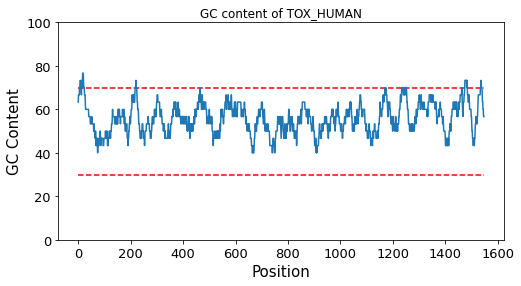

In [47]:
dp_metrics(name, opt_codon_seq, hosts, weight_params=weight_params, ref_codon=tox_human_dna)

## 2. TOX_MOUSE OS=m_musculus, OX=10090

In [90]:
name = 'TOX_MOUSE'
aa_seq = tox_mouse
weight_params = {'cub_h1': 1, 'cub_h2': 0, 'cpub_h1': 0, 'cpub_h2': 0, 'rep_nuc': 1, 'rho_T': 0.6, 'B_rho': 0.05}
hosts = ['e_coli', 'm_musculus']
opt_codon_seq = 'ATGGATGTAAGGTTTTATCCTCCCCCAGCTCAGCCAGCGGCCGCTCCGGCGGCGCCGTGCCTGGGCCCATCGCCGTGTCTGGATCCGTATTACTGCAATAAATTCGATGGTGAGAACATGTATATGTCCATGACCGAGCCGAGCCAGGACTACGTTCCGGCGAGCCAGAGCTACCCGGGTCCGAGCCTGGAATCCGAAGACTTCAACATTCCGCCGATCACGCCACCGTCGCTGCCGGACCACAGTCTGGTGCATCTGAACGAGGTGGAAAGCGGTTATCATTCCCTTTGCCATCCGATGAATCACAATGGTCTCCTGCCGTTCCACCCTCAAACGATGGATCTGCCGGAGATCACCGTTAGCAACATGCTGGGCCAGGACGGCGCCCTGTTGTCTAACTCCATCAGCGTCATGCAAGAAATTGGTAATGCGGAAGGTGCACAATATAGCAGCCACCCGCAGATGGCTGCTATGCGTCCGCGCGGTCAGCCGACCGACATCCGTCAGCAAGCCTCTATGATGCAACCGGGCCAGCTGACTACAATTAACCAGTCCCAGCTGAGCGCTCAATTGGGTTTGAATATGGGAGGCACCAATGTGGCGCACAACTCCCCGTCTCCGCCGGGCAGCAAGAGCGCCACCCCGTCCCCGTCGTCTAGCGTGCACGAGGACGAATGTGAAGATGCAAGCAAGATTAACGGCGGCGAGAAGCGCCCAGCGTCTGATATGGGTAAAAAGCCGAAAACCCCAAAAAAGAAGAAGAAGAAGGACCCGAACGAGCCGCAGAAACCGGTGTCTGCGTACGCACTGTTCTTTAGAGATACCCAGGCTGCGATTAAAGGTCAAAACCCGAACGCCACCTTTGGTGAGGTTTCAAAGATCGTGGCGAGCATGTGGGATGGCTTGGGCGAGGAACAGAAACAAGTTTATAAAAAGAAGACCGAGGCCGCGAAAAAAGAATACTTAAAACAGCTGGCAGCGTATCGTGCTTCACTGGTCAGCAAAAGCTACACCGACCCGGTTGATGTTAAAACGAGCCAGCCGCCACAATTGGTCAATTCTAAGCCGTCAGTGTTTCATGGTCCGTCCCAAGCGCACAGCGCGTTGTACCTAAGCAGCCATTATCACCAGCAGCCGGGTATGACCCCGCAACTGACTGCGATGCATCCGTCCTTACCCCGCAACATCGCGCCTAAGCCAAACAACCAGATGCCGGTCACGGTGTCTATCGCCAATATGGCAGTTAGCCCTCCGCCTCCGCTGCAGATTAGCCCACCGCTTCACCAACATCTGAGCATGCAGCAGCACCAGTCCCTGGCAATGCAACAGCCGTTGGGCTCGCAATTGCCGATGCAAGTTCAGACCGCGCTGCACTCACCAACGATGCAACAAGGTTTTACCCTGCAACCGGACTACCAGACCATTATCAACCCGACCTCCACCGCGGCGCAGGTAGTTACCCAGGCGATGGAATACGTACGTAGCGGGTGCCGTAATCCGCCGCCTCAACCGGTGGACTGGAGCACTGATTACTGCAGCTCAGGCGGTATGCAGCGTGACAAAGCACTTTATCTGACC'

In [81]:
H_codon = Codon_Hamiltonian(aa_seq, weight_params)
codon_opt = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1])
opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
opt_codon_seq

39 feasible solutions of 52.


'ATGGATGTACGCTTCTATCCGCCGCCGGCGCAGCCGGCTGCTGCTCCGGCTGCACCGTGTCTCGGTCCGTCGCCGTGTCTCGATCCGTACTACTGCAACAAGTTCGATGGCGAGAATATGTATATGAGCATGACTGAGCCATCACAGGACTACGTGCCGGCGTCGCAGAGCTATCCTGGTCCGTCGCTCGAGAGCGAGGACTTCAACATTCCGCCTATCACACCGCCATCTCTGCCGGATCACAGTCTGGTACATCTGAACGAAGTCGAGAGCGGCTATCATAGTCTGTGTCATCCGATGAATCATAACGGCCTGCTGCCGTTCCATCCGCAGACGATGGATCTGCCGGAGATCACTGTCTCGAACATGCTCGGTCAAGATGGTGCGCTGCTGTCTAATAGTATCAGCGTCATGCAGGAGATCGGCAATGCCGAAGGCGCGCAGTACAGCAGTCATCCTCAGATGGCTGCGATGCGTCCGCGCGGCCAGCCGACTGACATCCGTCAGCAGGCGTCGATGATGCAGCCAGGCCAGCTGACTACTATCAACCAGTCTCAGCTGAGCGCTCAGCTCGGCCTCAACATGGGTGGCACTAACGTCGCGCATAACTCGCCGTCACCGCCTGGCAGCAAGAGCGCTACTCCTTCGCCGAGCAGCTCAGTGCATGAGGATGAGTGTGAGGATGCGTCGAAGATTAACGGTGGTGAGAAGAGACCGGCGAGCGATATGGGCAAGAAGCCGAAGACACCGAAGAAGAAGAAGAAGAAGGATCCGAATGAACCGCAGAAGCCAGTGAGTGCGTATGCGCTGTTCTTCCGCGATACGCAGGCAGCGATCAAAGGTCAGAATCCGAATGCGACGTTCGGCGAAGTATCGAAGATCGTCGCGAGTATGTGGGATGGCCTTGGTGAAGAACAGAAGCAGGTCTATAAGAAGAAGACTGAGGCTGCTAAGAAGGAGTATCTGAAGCAGCTAGCTGCATATCGCGCTAGTCTCGTG

,Optimal Codon Seq
Similarity to ref_codon,0.768061
Effective number of codons,43.837435
GC,56.083650
GC3,65.589354


,e_coli,m_musculus
CAI,0.738052,0.668920
CPB,-0.113318,-0.523566


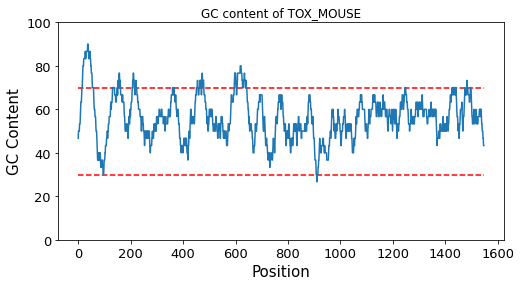

In [91]:
dp_metrics(name, opt_codon_seq, hosts, ref_codon=tox_mouse_dna)# weight_params=weight_params, 

## 3. WNT11_HUMAN OS=h_sapiens, OX=9606

In [65]:
name = 'WNT11_HUMAN'
aa_seq = wnt11_human
weight_params = {'cub_h1': 2, 'cub_h2': 1, 'cpub_h1': 1.8, 'cpub_h2': 1.8, 'rep_nuc': 1, 'rho_T': 0.51, 'B_rho': 0.05}
hosts = ['e_coli', 'h_sapiens']

In [66]:
H_codon = Codon_Hamiltonian(aa_seq, weight_params)
codon_opt = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1])
opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
opt_codon_seq

48 feasible solutions of 58.


'ATGCGTGCTCGTCCACAGGTGTGTGAGGCGCTGCTGTTCGCGCTGGCGCTGCAGACAGGTGTGTGCTATGGCATTAAGTGGCTGGCGCTGAGCAAGACACCATCAGCACTGGCGCTCAACCAGACGCAGCACTGTAAGCAGCTGGAAGGCCTGGTGTCTGCTCAGGTGCAGCTGTGTCGCAGCAACCTGGAGCTGATGCATACTGTGGTGCATGCAGCACGTGAAGTGATGAAGGCCTGTCGTCGTGCCTTCGCTGATATGCGCTGGAACTGCAGCAGCATCGAGCTGGCGCCGAACTATCTGCTGGATCTGGAGCGTGGTACACGTGAGAGTGCATTCGTCTATGCGCTGTCTGCTGCTGCTATCTCTCATGCTATCGCGCGTGCTTGTACATCAGGTGATCTGCCTGGCTGCAGCTGTGGTCCTGTTCCAGGTGAACCGCCAGGACCAGGCAACCGCTGGGGCGGCTGTGCAGATAACCTGAGCTATGGCCTGCTGATGGGTGCCAAGTTCAGTGATGCACCAATGAAGGTGAAGAAGACAGGTTCTCAGGCCAACAAGCTGATGCGTCTGCATAACAGTGAAGTTGGTCGTCAGGCGCTGCGTGCATCACTGGAGATGAAGTGTAAGTGTCATGGTGTCAGTGGCAGCTGCAGCATCCGCACCTGCTGGAAGGGCCTGCAGGAGCTGCAGGATGTAGCAGCAGATCTCAAGACGCGCTATCTCTCTGCAACCAAGGTGGTGCATCGTCCGATGGGAACTCGCAAGCATCTGGTGCCGAAGGATCTGGATATCCGTCCGGTGAAGGACAGTGAGCTGGTGTATCTGCAGTCATCACCAGACTTCTGCATGAAGAATGAGAAGGTTGGTTCTCATGGCACTCAGGATCGTCAGTGTAACAAGACCAGCAATGGCAGTGACAGCTGTGATCTGATGTGCTGTGGTCGTGGTTATAATCCTTATACTGATCGTGTGGTGGAGCGCTGCCACTGTAAGTAT

DNA name: WNT11_HUMAN                                           
                       cub_h1 cub_h2 cpub_h1 cpub_h2 rep_nuc rho_T B_rho
Weights                   2.0    1.0     1.8     1.8     1.0  0.51  0.05

,Optimal Codon Seq
Similarity to ref_codon,0.806026
Effective number of codons,36.098641
GC,55.838041
GC3,58.757062


,e_coli,h_sapiens
CAI,0.728445,0.769771
CPB,0.062773,0.077584


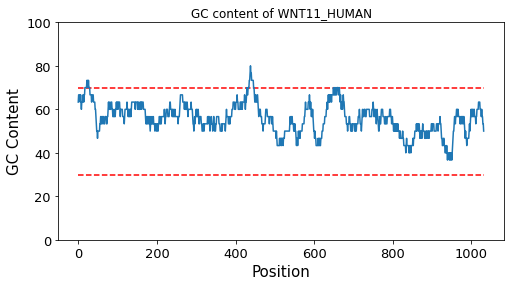

In [67]:
dp_metrics(name, opt_codon_seq, hosts, weight_params=weight_params, ref_codon=wnt11_human_dna) #

## 4. SPIKE_SARS2 Spike glycoprotein <br>
### OS=Severe acute respiratory syndrome coronavirus 2 OX=2697049

CAI(human): 0.70 $\pm$ 0.01

In [7]:
sars_cov_protein = SeqIO.read("./SARS_Cov2_glycoprotein_YP_009724390_datasets/protein.faa", "fasta").seq
sars_cov_gene = SeqIO.read("./SARS_Cov2_glycoprotein_YP_009724390_datasets/gene.fna", "fasta").seq

In [8]:
str(sars_cov_protein)

'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITG

In [152]:
name = 'SPIKE_SARS2 Spike glycoprotein'
aa_seq = sars_cov_protein
weight_params = {'cub_h1': 2, 'cpub_h1': 0.8, 'cub_h2': 0, 'cpub_h2': 0, 'rep_nuc': 0.5, 'rho_T': 0.37, 'B_rho': 0.01}
hosts = ['h_sapiens', 'sars_cov2']
#opt_codon_seq = 'ATGTTCGTGTTCCTGGTGCTGCTTCCTCTCGTGTCTTCTCAGTGCGTGAACCTGACAACCCGGACCCAGCTGCCGCCTGCCTACACCAACTCCTTTACTAGAGGCGTGTACTACCCTGACAAGGTGTTCAGGAGCAGCGTGCTGCACAGCACACAGGACCTGTTTCTGCCTTTCTTCAGCAACGTGACCTGGTTCCACGCCATACACGTATCCGGCACCAACGGAACCAAGCGATTTGACAATCCTGTGCTGCCTTTCAACGATGGCGTGTATTTTGCCTCTACCGAAAAAAGTAACATCATCCGGGGATGGATCTTCGGCACCACCCTGGATAGCAAGACCCAGAGCCTGTTGATCGTGAACAACGCCACCAACGTGGTGATTAAAGTGTGCGAGTTCCAGTTTTGCAACGACCCCTTCCTGGGCGTCTACTACCACAAGAACAACAAGAGCTGGATGGAATCTGAGTTCAGAGTGTACAGCAGCGCCAACAACTGTACCTTCGAGTACGTGAGCCAGCCATTCCTGATGGACCTGGAAGGCAAGCAAGGCAATTTTAAGAACCTTAGAGAATTCGTGTTCAAGAACATCGACGGCTACTTTAAAATCTACAGCAAGCACACGCCCATCAACCTGGTGCGGGATCTCCCACAGGGCTTTTCTGCTCTCGAGCCCCTGGTGGACCTGCCTATCGGAATCAACATCACCAGATTCCAGACACTGCTGGCTCTGCACAGAAGTTATCTAACCCCTGGCGACAGCAGCAGCGGCTGGACCGCCGGCGCTGCCGCCTACTACGTGGGTTACCTGCAGCCAAGAACATTTCTGCTGAAGTACAATGAGAACGGCACCATCACCGACGCCGTGGACTGCGCCCTGGATCCTCTGAGCGAAACCAAGTGCACACTGAAGAGCTTCACCGTGGAAAAGGGCATCTACCAGACGAGTAATTTCAGAGTGCAGCCTACCGAGTCCATCGTGCGGTTCCCTAACATCACCAACCTTTGTCCTTTCGGCGAGGTGTTTAACGCCACAAGATTCGCCTCCGTGTATGCTTGGAACAGAAAGAGAATCAGCAACTGCGTTGCCGACTATAGCGTGCTGTATAACAGCGCTTCTTTCAGCACATTCAAGTGCTACGGCGTTAGCCCTACAAAGCTGAACGATCTGTGCTTTACAAATGTGTACGCCGACAGCTTTGTGATCAGAGGCGATGAAGTGCGGCAGATCGCTCCTGGCCAGACTGGAAAGATCGCTGACTACAACTACAAGCTGCCTGATGACTTCACCGGCTGTGTTATCGCATGGAACAGCAACAACCTGGACAGCAAAGTGGGCGGCAACTACAACTACCTGTACCGGCTGTTCCGGAAGTCTAACCTGAAGCCCTTCGAGCGGGACATCTCCACAGAAATCTACCAAGCCGGCTCTACACCTTGTAACGGCGTGGAAGGTTTCAACTGCTACTTCCCCCTGCAGAGCTACGGCTTCCAGCCCACCAACGGGGTGGGCTATCAGCCCTACAGAGTGGTGGTGCTGAGCTTTGAGCTGCTCCACGCGCCAGCAACAGTCTGCGGACCTAAGAAGAGCACCAATCTGGTGAAGAACAAGTGCGTGAACTTTAACTTCAACGGCCTGACCGGAACCGGCGTGCTGACAGAGAGCAACAAAAAGTTCCTGCCCTTCCAGCAGTTCGGCAGAGATATCGCCGACACCACAGACGCCGTGAGGGATCCCCAGACCCTGGAAATCCTGGATATTACCCCCTGCAGCTTCGGCGGCGTCTCTGTGATCACACCAGGCACAAACACAAGCAACCAGGTGGCCGTGCTGTACCAGGACGTCAACTGCACCGAGGTTCCTGTCGCTATCCACGCCGACCAGTTAACCCCTACCTGGCGGGTGTACTCTACCGGTAGCAATGTGTTCCAGACCAGAGCCGGCTGCCTGATCGGCGCTGAACACGTGAACAACTCCTACGAGTGTGATATCCCTATTGGCGCCGGCATCTGTGCCAGCTACCAGACTCAAACAAACTCACCTCGCAGAGCCAGATCCGTGGCCAGCCAGAGCATCATCGCCTACACCATGAGCCTGGGCGCCGAGAACAGCGTGGCTTACAGCAATAACTCTATCGCCATCCCTACAAACTTCACGATCAGCGTGACCACCGAAATCCTGCCCGTGTCTATGACCAAAACCTCCGTGGACTGTACCATGTACATCTGCGGCGACAGCACAGAGTGCAGCAACCTCTTGCTGCAGTACGGCAGCTTCTGCACCCAGCTGAACCGGGCCCTGACCGGCATCGCCGTCGAACAGGATAAGAATACTCAGGAGGTGTTCGCCCAGGTGAAGCAGATCTACAAGACCCCGCCTATCAAGGACTTCGGAGGCTTCAATTTCAGCCAGATCCTGCCAGATCCATCTAAGCCTAGCAAGCGGTCCTTTATCGAGGATCTGCTGTTCAACAAGGTGACCCTGGCCGACGCCGGGTTCATCAAGCAGTACGGCGACTGCCTGGGAGACATCGCCGCCAGAGACCTGATCTGTGCCCAGAAGTTCAACGGCCTGACCGTGCTGCCTCCTCTGTTGACCGATGAGATGATCGCCCAGTACACCAGCGCCCTGCTGGCCGGAACTATTACAAGCGGCTGGACATTCGGCGCCGGAGCCGCTCTTCAGATCCCCTTCGCTATGCAGATGGCCTACAGATTCAACGGAATCGGTGTCACCCAAAATGTGCTGTACGAAAATCAAAAACTGATTGCTAACCAGTTCAATTCCGCCATCGGCAAAATCCAGGACAGCCTGTCTAGCACTGCCTCTGCCCTGGGAAAGCTGCAAGATGTGGTGAACCAGAACGCTCAGGCCCTGAACACTCTGGTGAAACAGCTGAGCTCCAATTTCGGCGCCATCTCAAGCGTGCTGAACGACATCCTGTCTAGGCTGGATAAGGTGGAGGCCGAAGTCCAGATTGATAGACTGATCACAGGCAGACTGCAGAGCCTGCAGACGTACGTTACCCAGCAGCTGATCAGAGCCGCCGAGATCCGAGCCAGTGCCAATCTGGCTGCCACAAAGATGTCTGAGTGCGTGCTGGGACAGTCCAAGCGGGTGGACTTCTGCGGCAAGGGCTACCATCTGATGAGCTTCCCTCAAAGCGCCCCCCACGGCGTGGTCTTCCTGCATGTGACATACGTGCCTGCCCAAGAGAAAAACTTTACAACCGCCCCTGCCATCTGCCACGACGGCAAGGCCCATTTCCCTAGAGAGGGCGTGTTCGTGAGCAACGGCACCCACTGGTTTGTGACCCAAAGAAACTTTTACGAGCCTCAGATAATCACCACAGATAACACCTTCGTGAGCGGAAATTGCGACGTGGTTATTGGCATTGTCAATAACACCGTGTACGACCCCCTGCAGCCTGAGCTGGACTCTTTCAAGGAAGAACTGGACAAGTACTTCAAGAATCACACCAGCCCCGATGTGGACCTGGGCGACATCAGCGGAATCAACGCCAGCGTAGTCAACATCCAGAAAGAAATCGACAGACTGAACGAGGTTGCAAAGAACCTGAACGAGTCCCTGATCGACCTGCAGGAGCTGGGCAAATACGAGCAGTACATCAAGTGGCCTTGGTACATCTGGCTGGGCTTCATCGCCGGCCTGATCGCTATCGTTATGGTGACAATCATGCTGTGCTGCATGACATCTTGCTGCAGCTGTCTGAAAGGCTGCTGCAGCTGTGGATCTTGCTGTAAATTCGACGAGGACGACTCAGAACCAGTGCTGAAGGGCGTGAAGTTGCACTACACA'

In [153]:
H_codon = Codon_Hamiltonian(aa_seq, weight_params)
codon_opt = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1], sampleset=False)
opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
opt_codon_seq

35 feasible solutions of 50.


'ATGTTTGTGTTCTTAGTATTACTGCCTTTAGTGTCTAGTCAGTGTGTGAATTTAACTACTAGAACACAGTTACCACCTGCATATACAAATTCATTCACTAGAGGAGTATATTATCCTGATAAGGTGTTCCGTTCATCAGTGCTGCATAGTACTCAGGATTTATTCTTACCATTCTTCAGTAATGTGACATGGTTCCATGCAATTCATGTATCTGGAACTAATGGTACTAAGAGATTTGATAATCCTGTATTACCATTCAATGATGGAGTGTATTTCGCATCTACAGAGAAGAGCAATATCATAAGAGGATGGATATTTGGAACTACTCTAGATAGTAAGACACAGTCACTGTTAATTGTGAATAATGCTACTAATGTAGTAATTAAGGTGTGTGAATTCCAGTTCTGTAATGATCCATTCTTAGGTGTATATTATCATAAGAATAATAAGTCATGGATGGAATCTGAGTTCAGAGTATATTCATCAGCTAATAATTGTACATTCGAATATGTATCTCAGCCATTCTTAATGGATCTTGAAGGTAAGCAAGGTAATTTCAAGAATCTGAGAGAATTCGTGTTCAAGAATATAGATGGATACTTCAAGATATATAGCAAGCATACTCCAATTAATTTAGTGAGAGATCTTCCTCAAGGATTCTCTGCTCTGGAACCACTTGTAGATTTACCAATTGGAATTAATATCACTAGATTCCAGACACTGCTAGCACTGCATAGATCATATCTGACACCAGGAGATAGTAGTAGTGGATGGACTGCAGGAGCTGCAGCATACTATGTTGGCTATCTGCAGCCAAGAACATTCTTACTGAAGTATAATGAGAATGGAACTATAACAGATGCTGTGGATTGTGCATTAGATCCATTAAGTGAGACTAAGTGTACTCTGAAGTCATTCACAGTGGAGAAAGGAATATATCAGACATCTAATTTCAGAGTGCAGCCAACAGAGTCTATAGTGAGATTTCCTAATATTACT

DNA name: SPIKE_SARS2 Spike glycoprotein                         \
                                          cub_h1 cpub_h1 cub_h2 cpub_h2   
Weights                                      2.0     0.8    0.0     0.0   

                             
        rep_nuc rho_T B_rho  
Weights     0.5  0.37  0.01

,Optimal Codon Seq
Similarity to ref_codon,0.775334
Effective number of codons,32.172902
GC,37.994239
GC3,29.693637


,h_sapiens,sars_cov2
CAI,0.721388,0.652132
CPB,0.073171,-1.229449


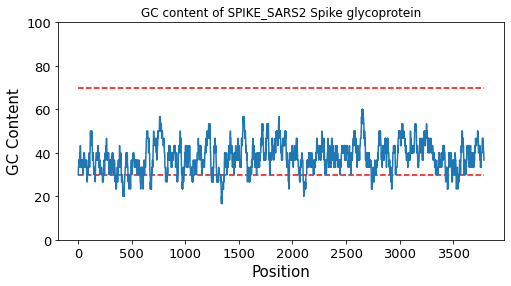

In [154]:
dp_metrics(name, opt_codon_seq, hosts, weight_params=weight_params, ref_codon=sars_cov_gene[:-3]) #

## 5. Insulin_sequence <br>
Homo sapiens chromosome 1_On '-' strand of Chromosome 11 (NC_000011.10)

In [1]:
insulin_human_dna = 'ATGGCCCTGTGGATGCGCCTCCTGCCCCTGCTGGCGCTGCTGGCCCTCTGGGGACCTGACCCAGCCGCAGCCTTTGTGAACCAACACCTGTGCGGCTCACACCTGGTGGAAGCTCTCTACCTAGTGTGCGGGGAACGAGGCTTCTTCTACACACCCAAGACCCGCCGGGAGGCAGAGGACCTGCAGGTGGGGCAGGTGGAGCTGGGCGGGGGCCCTGGTGCAGGCAGCCTGCAGCCCTTGGCCCTGGAGGGGTCCCTGCAGAAGCGTGGCATTGTGGAACAATGCTGTACCAGCATCTGCTCCCTCTACCAGCTGGAGAACTACTGCAACTAG'
insulin_human_protein = 'MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN'

In [12]:
res_codon = Amino_acid_to_Codon('L')
res_codon()

[['CUA', 'CUC', 'CUG', 'CUU', 'UUA', 'UUG']]

In [2]:
name = 'Insulin'
aa_seq = insulin_human_protein
weight_params = {'cub_h1': 1, 'cpub_h1': 0, 'cub_h2': 0, 'cpub_h2': 0, 'rep_nuc': 0, 'rho_T': 0.4, 'B_rho': 0.005}
hosts = ['e_coli', 'h_sapiens']
#opt_codon_seq = 

In [7]:
H_codon.N, H_codon.L

(412, 330)

In [5]:
H_codon = Codon_Hamiltonian(aa_seq, weight_params)
codon_opt = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1], sampleset=False)
opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
opt_codon_seq

102 feasible solutions of 118.


'ATGGCATTATGGATGCGTTTATTACCGCTGTTAGCATTACTGGCACTGTGGGGTCCGGATCCGGCAGCAGCATTTGTTAATCAACATTTATGTGGTTCTCATCTGGTTGAAGCATTATATTTAGTTTGTGGTGAACGTGGTTTTTTTTATACCCCGAAAACCCGTCGTGAAGCAGAAGATTTACAAGTTGGTCAGGTTGAACTGGGTGGTGGTCCGGGTGCAGGTTCTTTACAACCGTTAGCATTAGAAGGTAGTTTACAAAAACGTGGTATTGTTGAACAATGTTGTACCAGTATTTGTAGTCTGTATCAATTAGAAAATTATTGTAAT'

DNA name: Insulin                                            
                   cub_h1 cpub_h1 cub_h2 cpub_h2 rep_nuc rho_T  B_rho
Weights               1.0     0.0    0.0     0.0     0.0   0.4  0.005

,Optimal Codon Seq
Similarity to ref_codon,0.666667
Effective number of codons,22.227172
GC,40.303030
GC3,19.090909


,e_coli,h_sapiens
CAI,0.699147,0.510141
CPB,0.000236,0.082811


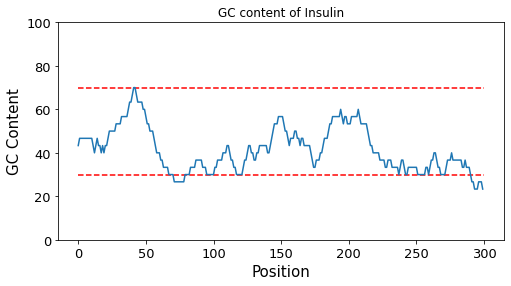

In [25]:
dp_metrics(name, opt_codon_seq, hosts, weight_params=weight_params, ref_codon=insulin_human_dna[:-3])

---
# Check Ground State Degeneracy !

In [92]:
genscript_res = 'ATGAGGGCTAGACCCCAAGTATGTGAAGCATTGTTGTTTGCCTTGGCGTTGCAAACCGGTGTCTGCTACGGCATTAAATGGCTGGCTCTGAGTAAAACTCCGAGCGCCTTGGCGTTGAATCAGACCCAGCATTGTAAGCAGCTGGAGGGTCTGGTAAGCGCGCAGGTGCAGCTGTGTCGTAGCAATCTAGAGCTGATGCATACCGTGGTTCATGCAGCTCGTGAGGTTATGAAGGCGTGCCGTAGAGCGTTCGCCGACATGCGTTGGAACTGCTCGAGCATCGAGCTGGCGCCAAATTACCTGTTGGACTTAGAGAGAGGCACCCGTGAGAGCGCGTTCGTTTATGCGCTGAGCGCGGCGGCTATCAGCCACGCAATTGCACGTGCGTGTACCAGCGGCGATCTTCCGGGTTGTTCGTGCGGTCCGGTTCCGGGTGAACCGCCAGGCCCGGGAAACCGTTGGGGTGGCTGCGCAGACAACCTGTCCTATGGCCTGCTGATGGGCGCAAAATTCAGCGATGCTCCGATGAAGGTGAAGAAAACCGGTAGCCAGGCTAATAAGCTGATGCGTCTGCATAACTCCGAAGTGGGTCGTCAGGCGCTGCGTGCCTCCCTGGAAATGAAGTGCAAATGCCACGGCGTGTCAGGTTCATGCAGCATTCGTACGTGCTGGAAAGGTTTACAAGAACTGCAAGATGTTGCAGCGGACCTAAAAACCCGCTACCTCTCTGCGACCAAAGTTGTTCACCGCCCTATGGGCACTCGCAAACACCTGGTCCCGAAGGACCTGGACATCCGTCCGGTCAAAGACAGCGAGTTGGTTTACCTCCAAAGCTCCCCGGATTTTTGCATGAAGAACGAAAAAGTGGGCTCCCACGGTACGCAGGATCGTCAATGTAACAAGACGAGCAACGGTTCTGACTCTTGCGATCTGATGTGCTGTGGCCGTGGTTATAACCCGTATACCGATCGCGTGGTGGAACGCTGCCACTGCAAGTACCATTGGTGCTGCTACGTGACCTGCCGCCGTTGTGAACGCACCGTCGAGCGCTATGTTTGTAAG'
dwave_res = 'ATGCGTGCTCGTCCACAGGTGTGTGAGGCGCTGCTGTTCGCGCTGGCGCTGCAGACAGGTGTGTGCTATGGCATTAAGTGGCTGGCGCTGAGCAAGACACCATCAGCACTGGCGCTCAACCAGACGCAGCACTGTAAGCAGCTGGAAGGCCTGGTGTCTGCTCAGGTGCAGCTGTGTCGCAGCAACCTGGAGCTGATGCATACTGTGGTGCATGCAGCACGTGAAGTGATGAAGGCCTGTCGTCGTGCCTTCGCTGATATGCGCTGGAACTGCAGCAGCATCGAGCTGGCGCCGAACTATCTGCTGGATCTGGAGCGTGGTACACGTGAGAGTGCATTCGTCTATGCGCTGTCTGCTGCTGCTATCTCTCATGCTATCGCGCGTGCTTGTACATCAGGTGATCTGCCTGGCTGCAGCTGTGGTCCTGTTCCAGGTGAACCGCCAGGACCAGGCAACCGCTGGGGCGGCTGTGCAGATAACCTGAGCTATGGCCTGCTGATGGGTGCCAAGTTCAGTGATGCACCAATGAAGGTGAAGAAGACAGGTTCTCAGGCCAACAAGCTGATGCGTCTGCATAACAGTGAAGTTGGTCGTCAGGCGCTGCGTGCATCACTGGAGATGAAGTGTAAGTGTCATGGTGTCAGTGGCAGCTGCAGCATCCGCACCTGCTGGAAGGGCCTGCAGGAGCTGCAGGATGTAGCAGCAGATCTCAAGACGCGCTATCTCTCTGCAACCAAGGTGGTGCATCGTCCGATGGGAACTCGCAAGCATCTGGTGCCGAAGGATCTGGATATCCGTCCGGTGAAGGACAGTGAGCTGGTGTATCTGCAGTCATCACCAGACTTCTGCATGAAGAATGAGAAGGTTGGTTCTCATGGCACTCAGGATCGTCAGTGTAACAAGACCAGCAATGGCAGTGACAGCTGTGATCTGATGTGCTGTGGTCGTGGTTATAATCCTTATACTGATCGTGTGGTGGAGCGCTGCCACTGTAAGTATCACTGGTGCTGCTATGTCACCTGTCGTCGCTGTGAGCGTACTGTCGAGCGCTATGTCTGTAAG'


In [93]:
len(genscript_res) == len(dwave_res)

True

In [94]:
len(np.argwhere(np.array(list(wnt11_human_dna)) != np.array(list(dwave_res))))

206

In [95]:
len(np.argwhere(np.array(list(wnt11_human_dna)) != np.array(list(genscript_res))))

255

In [18]:
def codon_usage_table(host = 'sars_cov2'):
    # Load codon usage bias table from CoCoPUTs
    df = pd.read_csv("./CUT_"+host+".csv")

    tables = pct.get_codons_table("e_coli_316407")

    for k, v in tables.items():
        for c in v.keys():
            #print(c, tables[k][c])
            tables[k][c] = df.loc[df['Codon'] == c].iat[0,1]

        tot = sum(list(v.values()))
        for c in v.keys():
            #print(c, tables[k][c])
            tables[k][c] = tables[k][c]/ tot

    return tables